In [1]:
import os
import string
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_utils as prep

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as tftext

In [2]:
VOCAB_SIZE = 20_000
MAX_SEQUENCE_LENGTH = 30

In [3]:
dir_path = os.path.join("datasets", "conll2003")

train_data = prep.read_iob_file(os.path.join(dir_path, "train.txt"))
valid_data = prep.read_iob_file(os.path.join(dir_path, "valid.txt"))
test_data = prep.read_iob_file(os.path.join(dir_path, "test.txt"))

x_train, vocab = prep.preprocess_tokens(train_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_train, class_names = prep.preprocess_entity_tags(train_data["entity_tags"], MAX_SEQUENCE_LENGTH)

x_valid, _ = prep.preprocess_tokens(valid_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_valid, _ = prep.preprocess_entity_tags(valid_data["entity_tags"], MAX_SEQUENCE_LENGTH)

x_test, _ = prep.preprocess_tokens(test_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_test, _ = prep.preprocess_entity_tags(test_data["entity_tags"], MAX_SEQUENCE_LENGTH)

In [4]:
print(f"Train examples:      {x_train.shape[0]}, vocabulary length: {len(vocab)}, classes: {len(class_names)}")
print(f"Validation examples: {x_valid.shape[0]}")
print(f"Test examples:       {x_test.shape[0]}")

Train examples:      14041, vocabulary length: 20000, classes: 9
Validation examples: 3250
Test examples:       3453


In [5]:
class SparseCategoricalCrossentropyIgnorePaddingLoss(keras.losses.Loss):
    def __init__(self, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits,
            reduction=keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.dtypes.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
        
        

In [6]:
inputs = layers.Input(shape=(None,))
x = layers.Embedding(VOCAB_SIZE, 64, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
outputs = layers.TimeDistributed(layers.Dense(10))(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                             

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=SparseCategoricalCrossentropyIgnorePaddingLoss(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
220/220 [==============================] - 2015s 9s/step - loss: 0.3180 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.2035 - val_sparse_categorical_accuracy: 0.8865
Epoch 2/10
220/220 [==============================] - 2329s 11s/step - loss: 0.1397 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.1894 - val_sparse_categorical_accuracy: 0.8896
Epoch 3/10
220/220 [==============================] - 954s 4s/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.2163 - val_sparse_categorical_accuracy: 0.8820
Epoch 4/10
220/220 [==============================] - 940s 4s/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.2424 - val_sparse_categorical_accuracy: 0.8665
Epoch 5/10
220/220 [==============================] - 954s 4s/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9430 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.8610
Epoch 6/10
220/220 [==============================] - 983s 4s/step - loss: 0.0662 - sparse_c

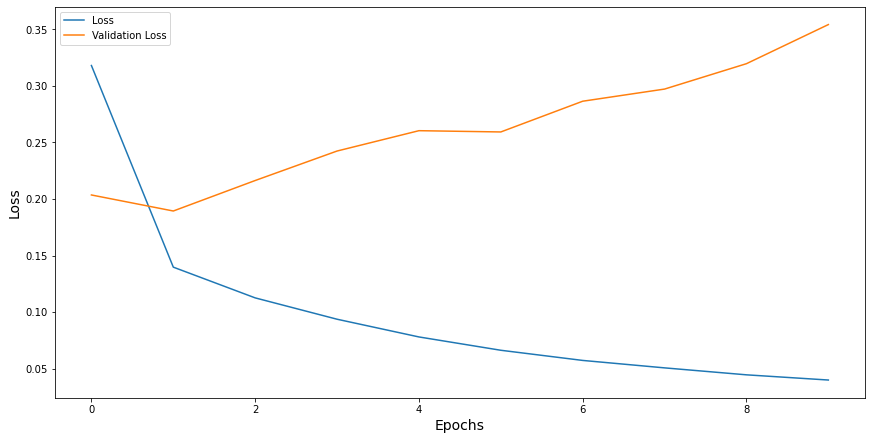

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend()
plt.show()

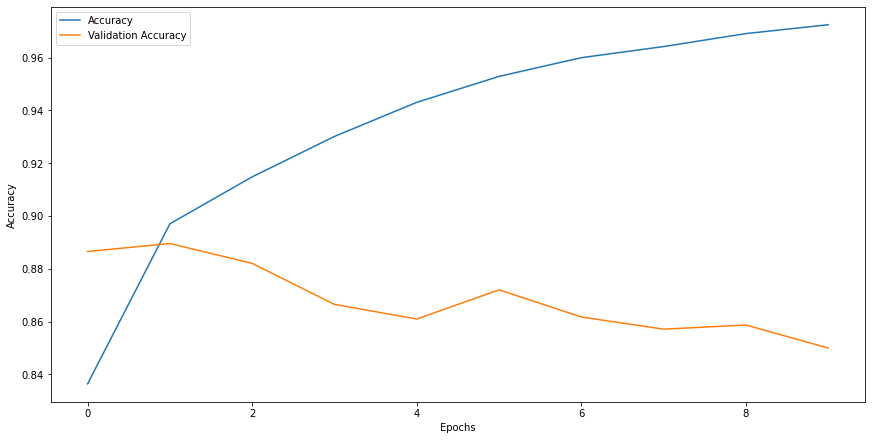

In [10]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(history.history["sparse_categorical_accuracy"], label="Accuracy")
ax.plot(history.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

In [11]:
results = model.evaluate(x_test, y_test)
print(results)

108/108 [==============================] - 28s 255ms/step - loss: 0.3397 - sparse_categorical_accuracy: 0.8328
[0.33970823884010315, 0.8327686786651611]


In [12]:
bert_model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess_model = hub.KerasLayer(bert_preprocessor_url)

NameError: name 'bert_preprocessor_url' is not defined

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
text_preprocessed = hub.KerasLayer(bert_model_url)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model_url}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
bert_results.keys()

In [ ]:
text_input = layers.Input(shape=(), dtype=tf.string, name="text")
preprocessing_layer = hub.KerasLayer(bert_preprocess_url, name="preprocessing")
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_model_url, trainable=True, name="BERT_encoder")
outputs = encoder(encoder_inputs)
net = outputs["pooled_output"]
net = layers.Dropout(0.1)(net)
net = layers.Dense(1, activation=None, name="classifier")(net)

In [ ]:
text_input = layers.Input(shape=(), dtype=tf.string, name="text")
preprocessing_layer = hub.KerasLayer(bert_preprocess_url, name="preprocessing")
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_model_url, trainable=True, name="BERT_encoder")
outputs = encoder(encoder_inputs)
net = outputs["sequence_output"]
# net = layers.Dropout(0.1)(net)
net = layers.TimeDistributed(layers.Dense(10, name="classifier"))(net)
model = keras.Model(inputs=text_input, outputs=net)

In [ ]:
model.summary()

In [ ]:
train_data.keys()

In [ ]:
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].